In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset_depresion_reducido.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008962 entries, 0 to 2008961
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   label           int64 
 1   processed_text  object
dtypes: int64(1), object(1)
memory usage: 30.7+ MB


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


In [5]:
df['label'].value_counts()

label
0    1547229
1     461733
Name: count, dtype: int64

In [6]:
# prompt: cámbiame label a int64

import numpy as np
df['label'] = df['label'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008962 entries, 0 to 2008961
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   label           int64 
 1   processed_text  object
dtypes: int64(1), object(1)
memory usage: 30.7+ MB


In [7]:
#df['text_input'] = df['title'].fillna('') + ' ' + df['body'].fillna('')

In [8]:
tfidf = TfidfVectorizer(
    max_features=1000,  # Aumentado de 500 a 1000 características
    ngram_range=(1, 3),  # Incluir unigramas, bigramas y trigramas
    max_df=0.90,  # Ignorar palabras que aparecen en más del 90% de los textos (probablemente stopwords o palabras muy comunes)
    min_df=5,     # Ignorar palabras que aparecen en menos de 5 textos (probablemente errores o casos muy específicos)
    binary=False  # False = usar frecuencias, True = solo presencia/ausencia
)
# Fill NaN values with empty strings before applying TfidfVectorizer
df['processed_text'] = df['processed_text'].fillna('')
X = tfidf.fit_transform(df['processed_text']).toarray()

In [9]:
y = df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

In [11]:
y_train.shape

(1707617,)

In [12]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15, random_state=42)

In [13]:
from keras.callbacks import EarlyStopping

In [14]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
early_stop = EarlyStopping(
  monitor='val_loss',
  patience=5,
  restore_best_weights=True
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks = [early_stop])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - accuracy: 0.9246 - loss: 0.1936 - val_accuracy: 0.9349 - val_loss: 0.1685
Epoch 2/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9377 - loss: 0.1645 - val_accuracy: 0.9375 - val_loss: 0.1631
Epoch 3/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - accuracy: 0.9412 - loss: 0.1563 - val_accuracy: 0.9374 - val_loss: 0.1627
Epoch 4/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - accuracy: 0.9439 - loss: 0.1502 - val_accuracy: 0.9372 - val_loss: 0.1639
Epoch 5/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9466 - loss: 0.1454 - val_accuracy: 0.9366 - val_loss: 0.1658
Epoch 6/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9478 - loss: 0.1428 - val_accuracy: 0.9363 - val_loss: 0.1692
Epoch 7/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 0.9493 - loss: 0.1398 - val_accuracy: 0.9364 - val_loss: 0.1704
Epoch 8/10
45359/45359 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - accuracy: 

In [15]:
model.save("modelo_depresion.keras")

In [16]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)

9418/9418 ━━━━━━━━━━━━━━━━━━━━ 3s 341us/step - accuracy: 0.9375 - loss: 0.1637


In [17]:
loss

0.16348367929458618

In [18]:
accuracy

0.9375068545341492

In [19]:
y_pred_probs = model.predict(X_test)  # Probabilidades
y_pred = (y_pred_probs > 0.5).astype(int)  # Convertir a clases (0 o 1)

9418/9418 ━━━━━━━━━━━━━━━━━━━━ 3s 287us/step


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Para clasificación binaria o multiclase:
precision = precision_score(y_test, y_pred, average='binary')  # 'binary' para binaria
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.88
Recall: 0.84
F1-score: 0.86


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


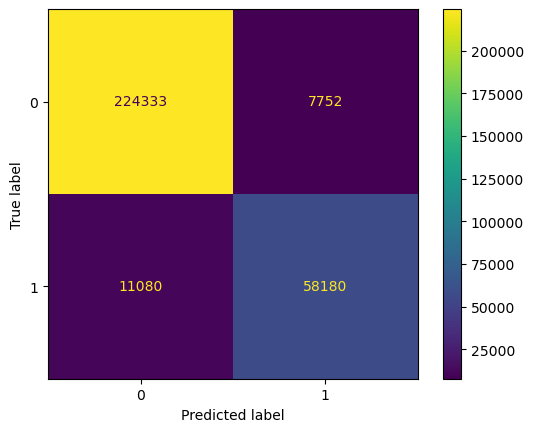

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()